# G-Research 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Load in all the relevant data
df = pd.read_csv("/scratch/hteagle/ML_data/train.csv")
asset_details = pd.read_csv("/scratch/hteagle/ML_data/asset_details.csv")

In [7]:
def asset_index(asset_name):
    return asset_details.loc[asset_details['Asset_Name']==asset_name]["Asset_ID"].values[0]
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods).rename("log_return")

In [8]:
def prepare_data(df):
    # Put all the data into a dict grouped by asset
    asset_dfs = {}
    log_returns = {}
    for _,asset in asset_details.iterrows():
        asset_dfs[asset.Asset_Name] = df[df["Asset_ID"]==asset['Asset_ID']]
        asset_dfs[asset.Asset_Name] = asset_dfs[asset.Asset_Name].reindex(range(asset_dfs[asset.Asset_Name].index[0],asset_dfs[asset.Asset_Name].index[-1]+60,60),method='pad')
        
        # Add useful log returns column
        log_returns = log_return(asset_dfs[asset.Asset_Name].Close).fillna(0)[1:]
        asset_dfs[asset.Asset_Name] = asset_dfs[asset.Asset_Name].join(log_returns, rsuffix=asset.Asset_Name, how="outer").fillna(0)
        asset_dfs[asset.Asset_Name]['Datetime'] = pd.to_datetime(asset_dfs[asset.Asset_Name]['timestamp'], unit='s')
        asset_dfs[asset.Asset_Name] = asset_dfs[asset.Asset_Name].set_index("Datetime")
    return asset_dfs
    
    

### Build the features as in the tutorial and scale them 

In [9]:
from sklearn.preprocessing import StandardScaler
# simple preprocessing of the data 
scaler = StandardScaler()

upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

def build_features_and_targets(df_dict):
    inputs = []
    targets = []
    for name,asset in df_dict.items():
        asset_input = pd.concat([log_return(asset.VWAP,periods=5), log_return(asset.VWAP,periods=1).abs(), 
                       upper_shadow(asset), lower_shadow(asset)], axis=1)
        asset_input.replace([np.inf, -np.inf], np.nan, inplace=True)
        asset_input = asset_input.fillna(0)
        #print(asset_input)
        scaler.fit(asset_input)
        asset_input = scaler.transform(asset_input)
        inputs.append(asset_input)
        target = asset['Target'].fillna(method="ffill")
        targets.append(target)
    return inputs, targets

In [10]:
def weighted_correlation(a, b, weights):

    w = np.ravel(weights)
    a = np.ravel(a)
    b = np.ravel(b)

    sum_w = np.sum(w)
    mean_a = np.sum(a * w) / sum_w
    mean_b = np.sum(b * w) / sum_w
    var_a = np.sum(w * np.square(a - mean_a)) / sum_w
    var_b = np.sum(w * np.square(b - mean_b)) / sum_w

    cov = np.sum((a * b * w)) / np.sum(w) - mean_a * mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return corr

### Plot the predictions and true values and predicted values and calculate the correlations

In [63]:
from sklearn.metrics import mean_squared_error
import math
global model_performances
model_performances = {}
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 4)

def plot_predictions(train, train_pred, test=None, test_pred=None, plot_range=None, model_name=None, model_params=None, show_plots=True):
    

    do_test=False
    if test is not None and test_pred is not None:
        do_test=True
    if plot_range is not None:
        assert type(plot_range) is tuple
        train = train[plot_range[0]:plot_range[1]]
        train_pred = train_pred[plot_range[0]:plot_range[1]]
        if do_test:
            test = test[plot_range[0]:plot_range[1]]
            test_pred = test_pred[plot_range[0]:plot_range[1]]
    if not do_test:
        for i,((_,train_col),(_,pred_col)) in enumerate(zip(train.iteritems(),train_pred.iteritems())):
            asset_name = asset_details.iloc[i]["Asset_Name"]
            if show_plots:
                plt.plot(train_col, label='train')
                plt.plot(pred_col, label='train prediction')
                plt.legend()
                plt.show()
            train_rmse = math.sqrt(mean_squared_error(train_col, pred_col))
            print('RMSE for train %s: %f'%(asset_name, train_rmse))
        # Calculate the overall metric (for first 8 classes)
        train_weights = np.tile(asset_details['Weight'][0:train_pred.shape[1]],len(train))
        train_score = weighted_correlation(train.loc[:,:(train_pred.shape[1]-1)],train_pred,train_weights)
        print("Weighted metric: train: %f"%(train_score))
    else:
        for i,((_,train_col),(_,pred_train),(_,test_col),(_,pred_test)) in enumerate(zip(train.iteritems(),train_pred.iteritems(),test.iteritems(),test_pred.iteritems())):
            if show_plots:
                plt.plot(train_col, label='train')
                plt.plot(pred_train, label='train prediction')
                plt.plot(test_col, label='test')
                plt.plot(pred_test, label='test prediction')
                plt.legend()
                plt.show()
            train_rmse = math.sqrt(mean_squared_error(train_col, pred_train))
            test_rmse = math.sqrt(mean_squared_error(test_col, pred_test))
            print('RMSE for train', f"{train_rmse}")
            print('RMSE for test', f"{test_rmse}")
            
        test_weights = np.tile(asset_details['Weight'][0:test_pred.shape[1]],len(test))
        test_score  = weighted_correlation(test.loc[:,:(test_pred.shape[1]-1)],test_pred,test_weights)
        
        train_weights = np.tile(asset_details['Weight'][0:train_pred.shape[1]],len(train))
        train_score = weighted_correlation(train.loc[:,:(train_pred.shape[1]-1)],train_pred,train_weights)
        
        overall_train_rmse = np.sqrt(mean_squared_error(train.loc[:,:(train_pred.shape[1]-1)],train_pred))
        overall_test_rmse = np.sqrt(mean_squared_error(test.loc[:,:(test_pred.shape[1]-1)],test_pred))
        

        model_performances[model_name] = {"train":train_score, "test":test_score, "train_rmse":overall_train_rmse, "test_rmse":overall_test_rmse, 'model_params':model_params}

        


        print("Weighted metric: train: %f, test: %f"%(train_score, test_score))
        print("Overall RMSE:   train: %f, test: %f"%(overall_train_rmse,overall_test_rmse))  
        

In [57]:
asset_dfs = prepare_data(df)

In [58]:
# Incase we want to split up into test and train
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
splits = list(tscv.split(asset_dfs['Bitcoin']))

In [14]:
inputs,targets = build_features_and_targets(asset_dfs)

/user/hteagle/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/user/hteagle/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/user/hteagle/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/user/hteagle/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int

In [15]:
# Get the inputs that have the same number of entries
inputs_s = [i for i in inputs if i.shape == inputs[0].shape]
targets_s = [i for i,j in zip(targets,inputs) if j.shape == inputs[0].shape]

In [16]:
# Concatenate the series'
X = np.concatenate(inputs_s, axis=1)
y = np.column_stack(targets_s)

## Linear Regression

### Linear Regression for targets

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
clf = MultiOutputRegressor(LinearRegression())
clf.fit(X,y)
preds_train = clf.predict(X)

In [18]:
# Put the predictions into time series using the indices from the original dataset
y_series    = pd.DataFrame(data=y,index=asset_dfs['Bitcoin'].index)
preds_train = pd.DataFrame(data=preds_train, index=asset_dfs['Bitcoin'].index)

/user/hteagle/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


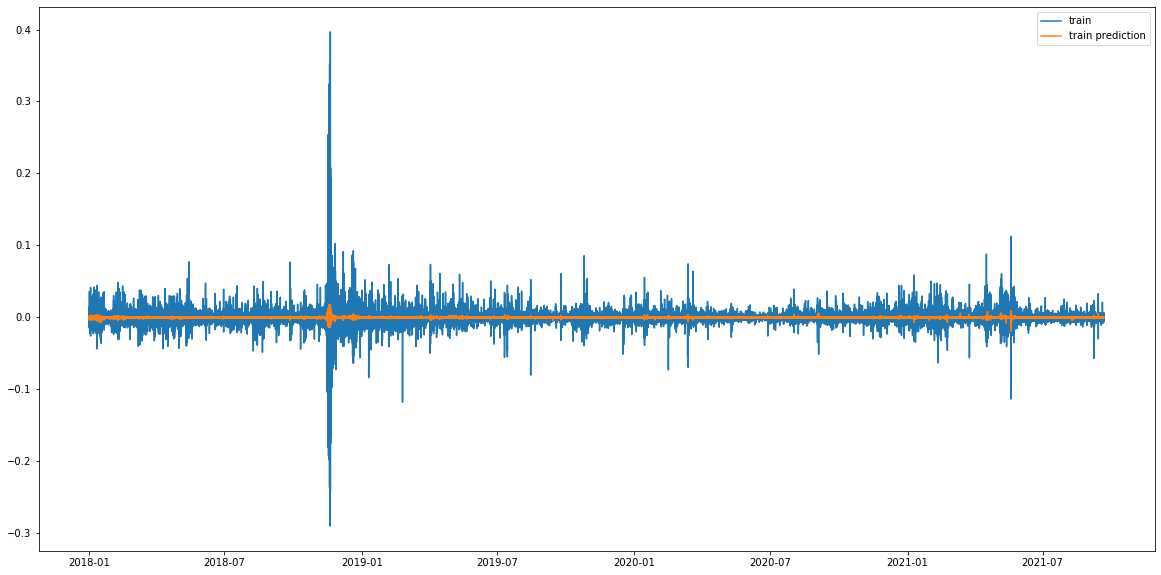

RMSE for train Bitcoin Cash: 0.006466


/user/hteagle/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


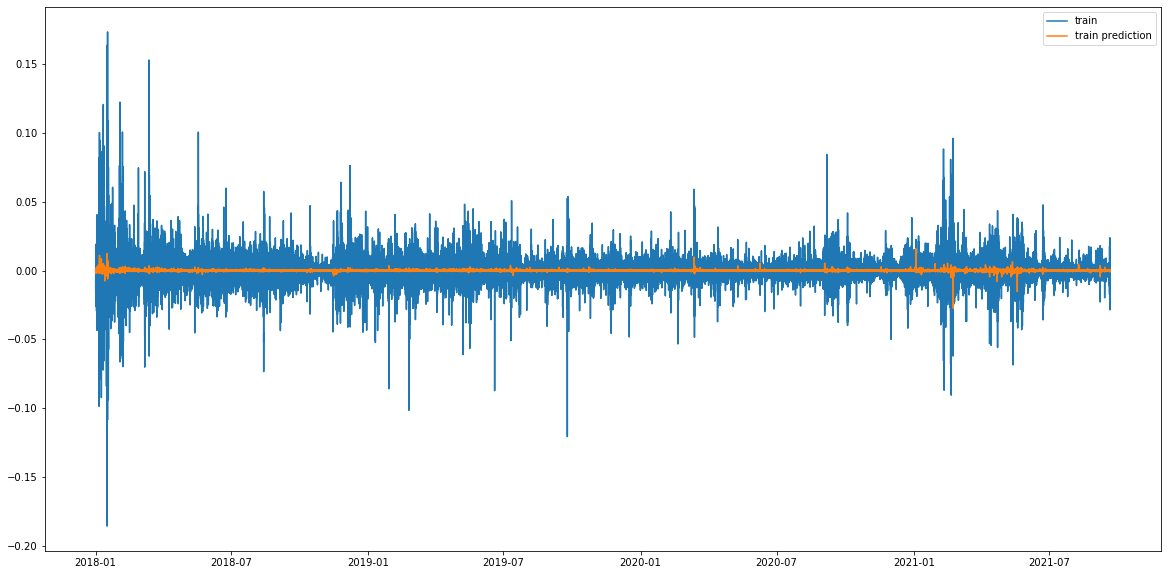

RMSE for train Binance Coin: 0.005057


/user/hteagle/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


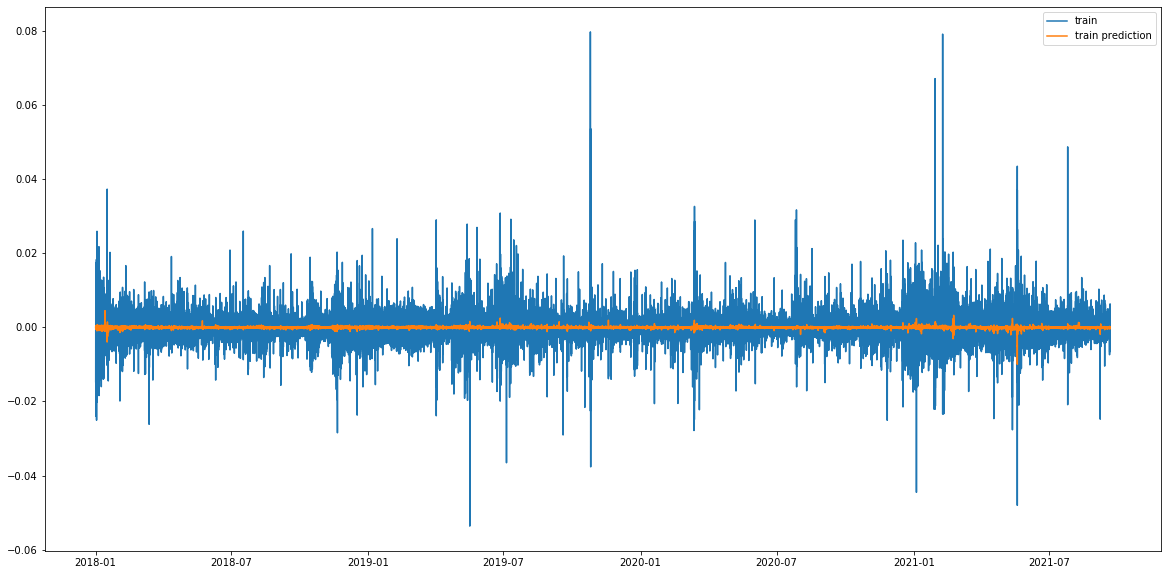

RMSE for train Bitcoin: 0.002011


/user/hteagle/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


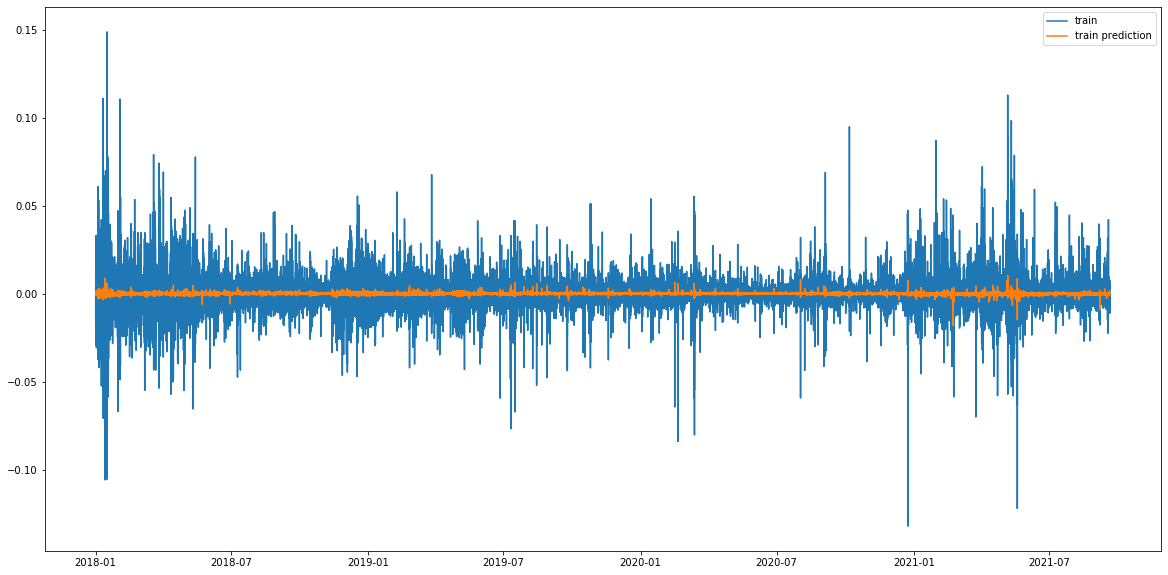

RMSE for train EOS.IO: 0.004593


/user/hteagle/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


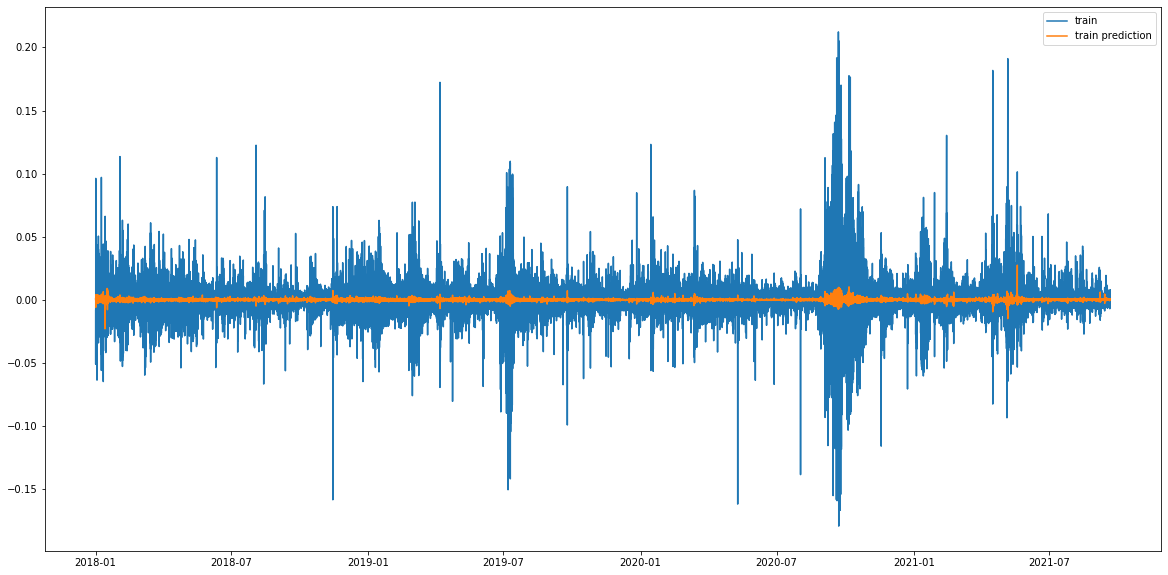

RMSE for train Ethereum Classic: 0.009046


/user/hteagle/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


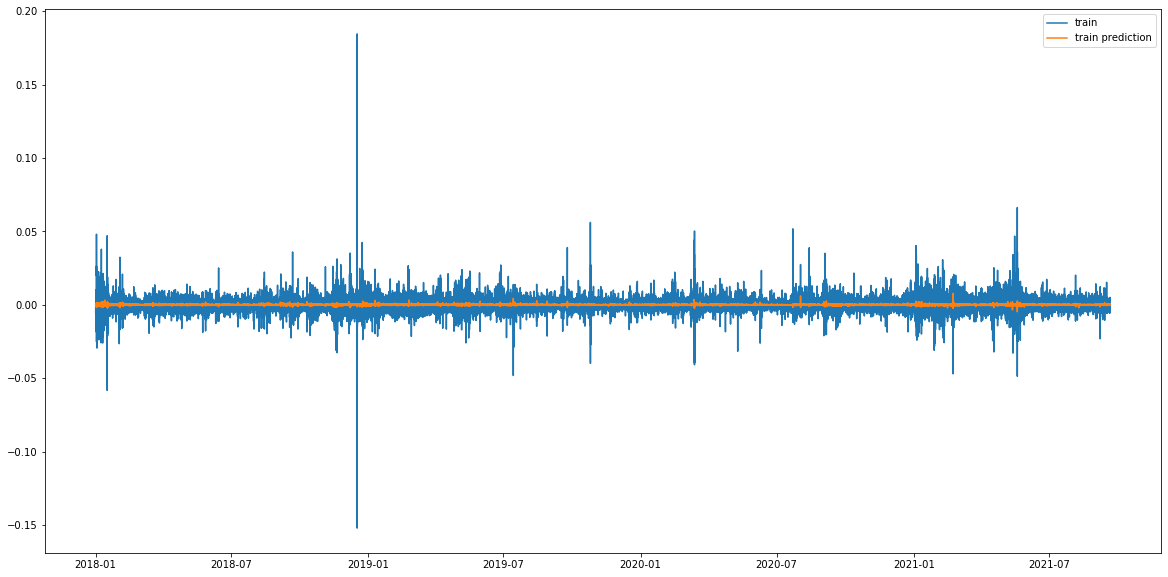

RMSE for train Ethereum: 0.002499


/user/hteagle/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


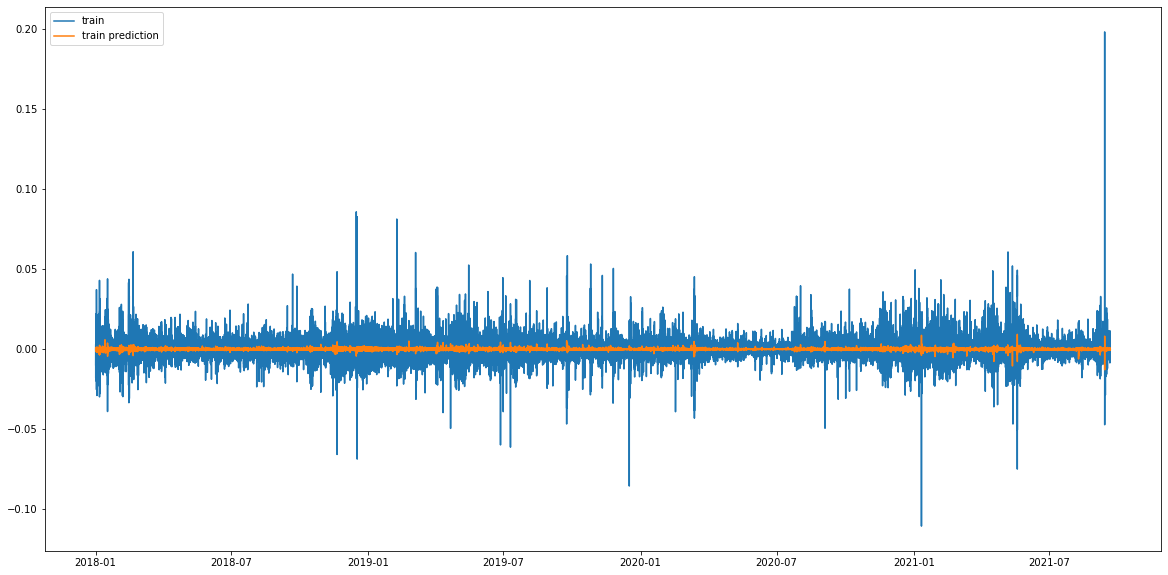

RMSE for train Litecoin: 0.003536


/user/hteagle/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


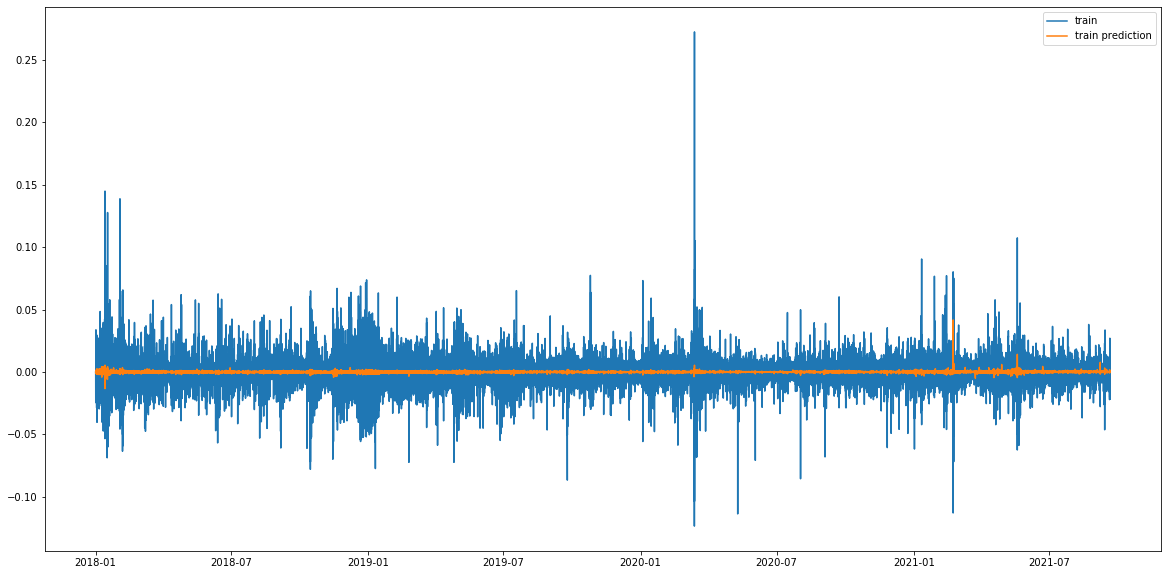

RMSE for train Monero: 0.005646
Weighted metric: train: 0.054794


In [19]:
plot_predictions(y_series,preds_train, model_name="linear regression")#, plot_range=('2018-01-01','2018-02-01'))

## XGB Regressor

In [45]:
def predict_and_evaluate(model, X, y, model_name, model_params):
    xgb_preds_train = model.predict(X[:splits[-1][0][-1]])
    xgb_preds_test = model.predict(X[splits[-1][1][0]:])

    xgb_preds_train = pd.DataFrame(data=xgb_preds_train, index=asset_dfs['Bitcoin'][:splits[-1][0][-1]].index)
    xgb_preds_test = pd.DataFrame(data=xgb_preds_test, index=asset_dfs['Bitcoin'][splits[-1][1][0]:].index)

    y_train = pd.DataFrame(data=y[:splits[-1][0][-1]], index=asset_dfs['Bitcoin'][:splits[-1][0][-1]].index)
    y_test = pd.DataFrame(data=y[splits[-1][1][0]:], index=asset_dfs['Bitcoin'][splits[-1][1][0]:].index)
    plot_predictions(y_train, xgb_preds_train, test=y_test, test_pred=xgb_preds_test, model_name=model_name, model_params=model_params)

In [65]:
import xgboost
def define_fit_evaluate_xgb(parameters_dict, X, y, model_name):
    d = parameters_dict
    model = xgboost.XGBRegressor(n_estimators=d['n_estimators'], max_depth=d['max_depth'], eta=d['eta'], subsample=['subsample'], colsample_bytree=['colsample_bytree'], tree_method='gpu_hist')
    clf_xgb = MultiOutputRegressor(model)
    %time clf_xgb.fit(X[:splits[-1][0][-1]], y[:splits[-1][0][-1]])
    predict_and_evaluate(clf_xgb, X, y, model_name, model.__dict__)

In [75]:
class series_splitter:
    """Splits time series data by number of steps"""
    def __init__(self, n_steps=5):
        self.n_steps = n_steps
    def split_series(self, X, y):
        assert len(X) == len(y)
        i=0
        X_ts = []
        y_ts = []
        while (i+self.n_steps) < len(y):
            X_ts.append(X[i:(i+self.n_steps)].flatten())
            y_ts.append(y[(i+self.n_steps)])
            i = i + self.n_steps
        return np.asarray(X_ts), np.asarray(y_ts)
        

In [ ]:
ss = series_splitter(n_steps=5)
X_ts, y_ts = ss.split_series(X[:10],y[:10])

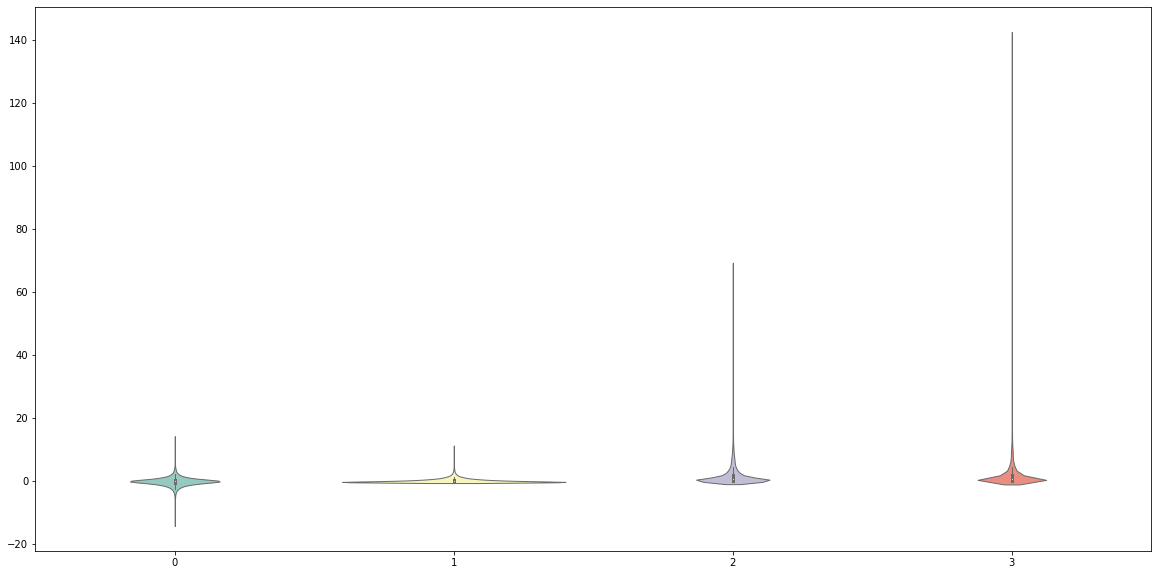

In [20]:
import seaborn as sns
sns.violinplot(data=X_btc_xgb[:splits[-1][0][-1],:4], palette="Set3", bw=.2, cut=1, linewidth=1)

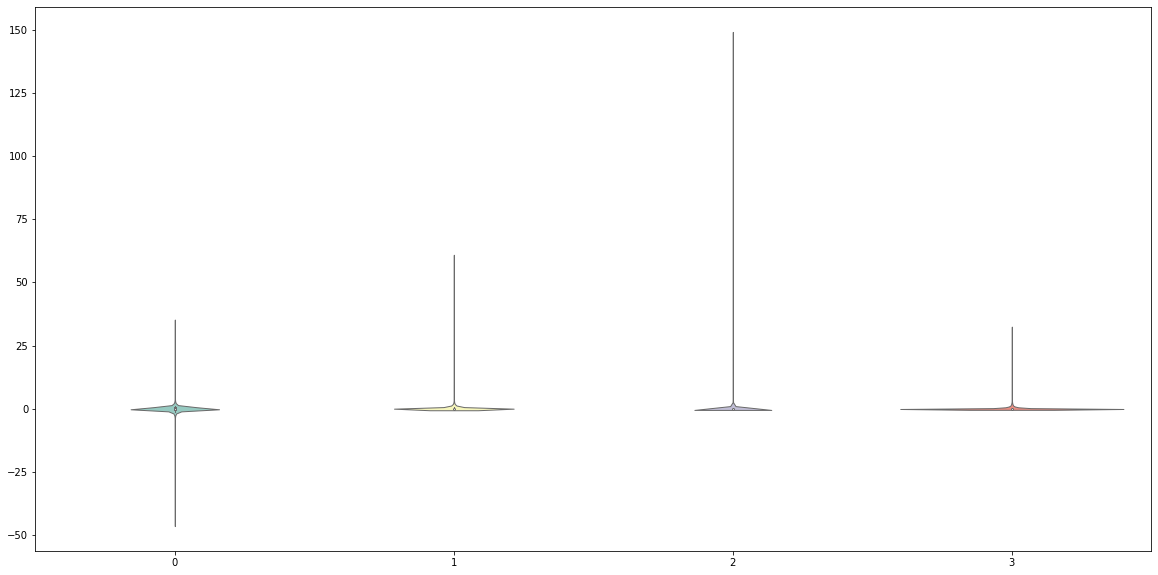

In [21]:
sns.violinplot(data=X_btc_xgb[splits[-1][1][0]:,:4], palette="Set3", bw=.2, cut=1, linewidth=1)

## LSTM

### Prepare data for input to LSTM, expects data shape [samples,time steps, features]

### Build LSTM model

In [16]:
ss = sequence_splitter(n_steps=15)
(X_btc_ts, y_btc_ts) = ss.split_sequences(X, y)


NameError: name 'sequence_splitter' is not defined

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2021-12-14 10:51:28.606139: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [23]:
def define_and_fit_single(neurons, epochs, batch_size, X_train, y_train, X_test, y_test):
    model = keras.Sequential()
    model.add(layers.LSTM(neurons, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(layers.Dense(8))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    return model, history
    

In [24]:
# plot history
def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [25]:
def predict_and_eval(model, model_name, X_train, X_test, y_train, y_test, sequence_splitter, plot_range=None):
    preds_train_lstm = model.predict(X_train)
    preds_test_lstm = model.predict(X_test)
    #Convert back to datetime series
    preds_train_lstm = pd.DataFrame(data=preds_train_lstm, index=asset_dfs['Bitcoin'][:splits[-1][0][-1]].index)
    y_train = pd.DataFrame(data=y_train, index=asset_dfs['Bitcoin'][:splits[-1][0][-1]].index)
    preds_test_lstm = pd.DataFrame(data=preds_test_lstm, index=asset_dfs['Bitcoin'][splits[-1][1][0]:-(sequence_splitter.n_steps)].index)
    y_test = pd.DataFrame(data=y_test, index=asset_dfs['Bitcoin'][splits[-1][1][0]:-(sequence_splitter.n_steps)].index)
    plot_predictions(y_train,preds_train_lstm, test = y_test, test_pred = preds_test_lstm, model_name=model_name, plot_range=plot_range)
    

In [26]:
model, history = define_and_fit_single(neurons = 50, epochs = 20, batch_size = 1000, 
                                       X_train = X_btc_ts[:splits[-1][0][-1],:,:], 
                                       y_train = y_btc_ts[:splits[-1][0][-1]],
                                       X_test  = X_btc_ts[splits[-1][1][0]:,:,:],
                                       y_test  = y_btc_ts[splits[-1][1][0]:],
                                      )
plot_history(history)

2021-12-14 10:51:50.810530: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-14 10:51:50.837527: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-14 10:51:51.604726: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-14 10:51:51.604819: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kappa.ph.liv.ac.uk): /proc/driver/nvidia/version does not exist
2021-12-14 10:51:51.606464: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
predict_and_eval(model, 
                        X_train = X_btc_ts[:splits[-1][0][-1],:,:], 
                        y_train = y_btc_ts[:splits[-1][0][-1]],
                        X_test  = X_btc_ts[splits[-1][1][0]:,:,:],
                        y_test  = y_btc_ts[splits[-1][1][0]:],
                        model_name = "trial1",
                        sequence_splitter = ss,
                       )

In [ ]:
model_performances